In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import sklearn

from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import History
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPool2D
import numpy
%matplotlib inline


Using TensorFlow backend.


# Part one: Load the local data

Data downloaed from https://www.kaggle.com/paultimothymooney/breast-histopathology-images

In [2]:
imagePatches = glob('D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\10253\0\10253_idx5_x1001_y1001_class0.png
D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\10253\0\10253_idx5_x1001_y1051_class0.png
D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\10253\0\10253_idx5_x1001_y1101_class0.png
D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\10253\0\10253_idx5_x1001_y1151_class0.png
D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\10253\0\10253_idx5_x1001_y1201_class0.png
D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\10253\0\10253_idx5_x1001_y1251_class0.png
D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\10253\0\10253_idx5_x1001_y1301_class0.png
D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\10253\0\10253_idx5_x1001_y1351_class0.png
D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\10253\0\10253_idx5_x1001_

In [3]:
# As we can see, all images are classified and its file name contain the category
# create list divided by category

patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n", classZero[0:5], '\n')
print("IDC(+)\n\n", classOne[0:5])

IDC(-)

 ['D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\\10253\\0\\10253_idx5_x1001_y1001_class0.png', 'D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\\10253\\0\\10253_idx5_x1001_y1051_class0.png', 'D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\\10253\\0\\10253_idx5_x1001_y1101_class0.png', 'D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\\10253\\0\\10253_idx5_x1001_y1151_class0.png', 'D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\\10253\\0\\10253_idx5_x1001_y1201_class0.png'] 

IDC(+)

 ['D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\\10253\\1\\10253_idx5_x501_y351_class1.png', 'D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\\10253\\1\\10253_idx5_x501_y401_class1.png', 'D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images\\10253\\1\\10253_idx5_x551_y301_class1.png', 'D:/99_Project_Data/00_BreastCan

# Data Explore

#### Understanding the dataset
The dataset we use was downloded from Kaggle(https://www.kaggle.com/paultimothymooney/breast-histopathology-images)

The dataset consists of 162 whole mount slide images of breast cancer specimens scanned at 40x. From that,277,524 patches of size 50 x 50 were extracted, out of which 198,738 are IDC negative (benign) and 78,786 are IDC positive (malignant).

In [117]:
def read_img(img):
    img = cv2.imread(img)
    img = cv2.resize(img, (50,50))
    
    return img

# Part Two: Dataset Analysis and Data Augmentation

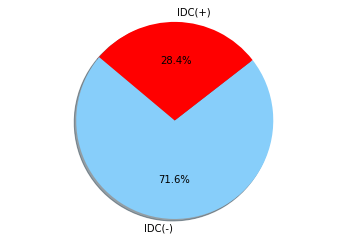

In [5]:
# plot the portion of negative and posive data
labels = 'IDC(-)', 'IDC(+)'
sizes = [len(classZero), len(classOne)]
colors = ['lightskyblue','red']

# plot
plt.pie(sizes, labels=labels, colors = colors,
       autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

According to above pie graph, negative cancer cases are much more than positive ones. Therfore, in order to get balanced dataset portion of cases, we can use data augmentation to 

In [23]:
def augmentation1(img):
    img = cv2.imread(img)
    img = cv2.resize(img, (50,50))
    augmented_img = np.fliplr(img)
    
    return augmented_img

def augmentation2(img):
    img = cv2.imread(img)
    img = cv2.resize(img, (50,50))
    augmented_img = np.flipud(img)
    
    return augmented_img

def inverted(img):
#    img = cv2.resize(img, (50,50))
    img = Image.open(img)
    inverted_img = PIL.ImageOps.invert(image)

"""
def noisy(image_name):
    image = cv2.imread(image_name)
    noisy = np.random.poisson(image / 255.0 * 300) / 300 * 255
    noisy = cv2.resize(noisy, (50,50))
    noisy = noisy.astype(numpy.uint8)
    return noisy
"""

'\ndef noisy(image_name):\n    image = cv2.imread(image_name)\n    noisy = np.random.poisson(image / 255.0 * 300) / 300 * 255\n    noisy = cv2.resize(noisy, (50,50))\n    noisy = noisy.astype(numpy.uint8)\n    return noisy\n'

## An original image from dataset

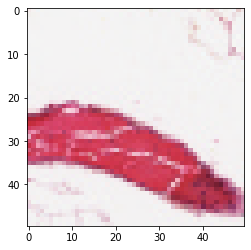

In [8]:
image_name = 'D:/99_Project_Data/00_BreastCancer_Images/breast-histopathology-images/9383/0/9383_idx5_x101_y751_class0.png'
image = cv2.imread(image_name)
image = cv2.resize(image, (50,50))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## Image output from augmentation functions

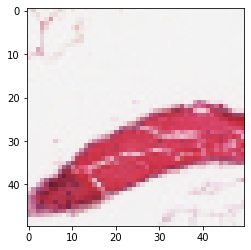

In [9]:
image = augmentation1(image_name)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

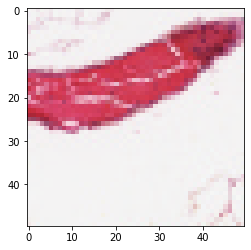

In [10]:
image = augmentation2(image_name)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [11]:
from PIL import Image
import PIL.ImageOps 

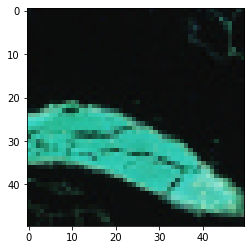

In [35]:
image = Image.open(image_name)
inverted_image = PIL.ImageOps.invert(image)
#imge = noisy(image_name)
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.imshow(inverted_image)

In [81]:
"""
    x is an array of resized images
    y is an array of labels
"""

X = []
Y = []
WIDTH = 50
HEIGHT = 50
for img in imagePatches[0:9000]:
    X.append(read_img(img))
    if img in classZero:
        Y.append(0)
    elif img in classOne:
        a1img = augmentation1(img)
#        a2img = augmentation1(img)
        img2 = Image.open(img)
        nimg = PIL.ImageOps.invert(img2)
#        nimg = noisy(inverted_image)
        X.append(a1img)
        X.append(a2img)
        X.append(nimg)
        Y.append(1)
        Y.append(1)
        Y.append(1)
        Y.append(1)
    else:
        break
        


In [171]:
# def process_images(lowerIndex,upperIndex):
"""
Returns two arrays: 
    x is an array of resized images
    y is an array of labels
""" 
height = 50
width = 50
channels = 3
X = [] #list to store image data
Y = [] #list to store corresponding class
for img in imagePatches[0:7000]:
    img2 = Image.open(img)
    nimg = PIL.ImageOps.invert(img2)
    img3 = np.array(nimg)
    X.append(img3)
#    full_size_image = cv2.imread(img)
#    image = (cv2.resize(full_size_image, (width,height), interpolation=cv2.INTER_CUBIC))
#    X.append(image)
    if img in classZero:
        Y.append(0)
    elif img in classOne:
        Y.append(1)
    else:
        break
#        return
# return X,Y

In [160]:
X

[array([[[ 29,  91,  49],
         [ 31, 101,  59],
         [ 30,  80,  44],
         ...,
         [ 15,  34,  18],
         [ 23,  71,  41],
         [ 12,  42,  20]],
 
        [[ 38, 113,  67],
         [ 34, 125,  76],
         [ 31, 105,  59],
         ...,
         [ 28,  85,  51],
         [ 26,  75,  40],
         [ 19,  43,  23]],
 
        [[ 18,  77,  43],
         [ 26,  98,  56],
         [ 37, 130,  80],
         ...,
         [ 34,  71,  38],
         [ 65, 102,  62],
         [ 28,  91,  47]],
 
        ...,
 
        [[ 38, 110,  63],
         [ 41, 126,  71],
         [ 43, 126,  72],
         ...,
         [ 61, 133,  70],
         [ 51, 112,  62],
         [ 66, 126,  67]],
 
        [[ 37, 111,  63],
         [ 42, 127,  70],
         [ 47, 134,  84],
         ...,
         [119, 176, 110],
         [ 71, 144,  81],
         [ 67, 143,  79]],
 
        [[ 43, 130,  74],
         [ 44, 119,  74],
         [ 35,  93,  49],
         ...,
         [128, 165, 103],
  

In [172]:
X = np.array(X)
X = X.astype(np.float32)
X /= 255.

In [1]:
labels = 'IDC(-)', 'IDC(+)'
sizes = [len(classZero), len(classOne)*3]
colors = ['lightskyblue','red']

#plot

plt.pie(sizes,labels=labels, colors = colors, autopct = '%1.1f%%', shadow=True, startangle = 140)

NameError: name 'classZero' is not defined

In [173]:
X=np.array(X)
#split the dataset in 80:20 for training and validating.

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

print("Training Data Shape :", X_train.shape)
print("Testing Data Shape :", X_test.shape)

Training Data Shape : (5600, 50, 50, 3)
Testing Data Shape : (1400, 50, 50, 3)


In [174]:
print('Y :',len(Y))
print('X :',len(X))

Y : 7000
X : 7000


In [175]:
len(X_train)

5600

In [176]:
len(X_test)

1400

In [177]:
len(y_train)

5600

In [178]:
len(y_test)

1400

In [98]:
imgs1 = []
imgs0 = []
for x in range(500):
    if y_train[x] == 1:
        imgs1.append(X_train[x])
    if y_train[x] == 0:
        imgs0.append(X_train[x])

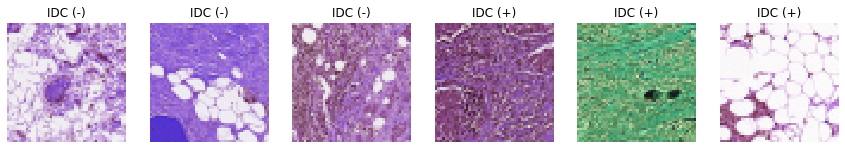

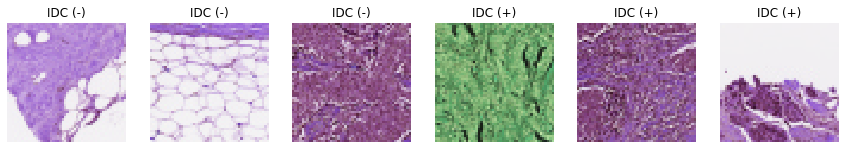

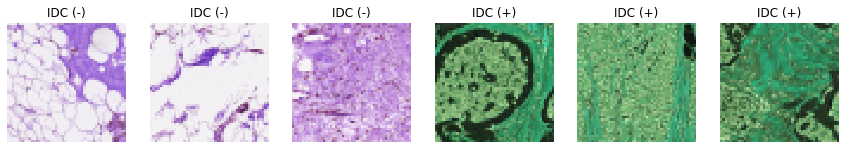

In [99]:
for row in range(3):
    plt.figure(figsize=(20,10))
    for col in range(3):
        plt.subplot(1,8,col+1)
        plt.title('IDC (-)')
        plt.imshow(imgs0[0+4*row+col])
        plt.axis('off')
        plt.subplot(1,8,col+4)
        plt.title('IDC (+)')
        plt.imshow(imgs1[0+4*row+col])
        plt.axis('off')

<blank>

In [103]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3),
                activation='relu',
                input_shape=(50,50,3),
                strides=2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1 ,activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 32)        896       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               991360    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [110]:
Datagen = ImageDataGenerator(
    rotation_range=90, # randomly ratate images in the range (degree, 0 to 180)
    width_shift_range=0.2, # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2, # randomly shift images vertically (fraction of total height) 
    horizontal_flip=True, # randomly flip images
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True) # randomly flip images


In [107]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [115]:
Batch_size = 32

from keras.callbacks import History
history = History()
history = model.fit_generator(Datagen.flow(X_train, y_train, batch_size=32), 
                              steps_per_epoch=len(X_train) /Batch_size,
                              validation_data = (X_test,y_test), epochs=EPOCHS)

ValueError: setting an array element with a sequence.

In [179]:
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

##### install imbalanced-learn
pip install imbalanced-learn --user

In [182]:
from imblearn.under_sampling import RandomUnderSampler
random_under_sampler = RandomUnderSampler(ratio='majority')
X_trainRos, Y_trainRos = random_under_sampler.fit_sample(X_trainFlat, y_train)
X_testRos, Y_testRos = random_under_sampler.fit_sample(X_testFlat, y_test)

ModuleNotFoundError: No module named 'sklearn.neighbors._base'